# Introduction
<hr style = "border:2px solid black" ></hr>


**What?** Common alpha factors - functions group in TA-Lib



# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [3]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

# Load Data
<hr style = "border:2px solid black" ></hr>

In [5]:
start = dt.datetime(2012, 1, 1)
data = pdr.get_data_yahoo("AAPL", start)

[*********************100%***********************]  1 of 1 completed


In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.482926,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.550012,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.689340,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.821993,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.801655,394024400


In [7]:
data = data.rename(columns={"Close": "close", "Low": "low", "High": "high", "Volume": "volume"})

In [8]:
data.head()

,Open,high,low,close,Adj Close,volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.482926,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.550012,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.689340,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.821993,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.801655,394024400


In [9]:
data["Date"] =  data.index

In [10]:
data.index.min()

Timestamp('2012-01-03 00:00:00')

In [11]:
data.index.max()

Timestamp('2023-07-21 00:00:00')

In [12]:
price_sample = data

In [13]:
#data = pd.read_hdf('data.h5', 'data/top500')
#price_sample = pd.read_hdf('data.h5', 'data/sample')

## TA-Lib: Function Groups

List number of available functions by group

In [14]:
function_groups = ['Overlap Studies',
                   'Momentum Indicators',
                   'Volume Indicators',
                   'Volatility Indicators',
                   'Price Transform',
                   'Cycle Indicators',
                   'Pattern Recognition',
                   'Statistic Functions',
                   'Math Transform',
                   'Math Operators']

In [15]:
talib_grps = talib.get_function_groups()

|Function Group  | # Indicators  |
|:---|---|
|Overlap Studies	| 17|
|Momentum Indicators	| 30|
|Volume Indicators	| 3|
|Volatility Indicators	| 3|
|Price Transform	| 4|
|Cycle Indicators	| 5|
|Pattern Recognition	| 61|
|Math Operators	| 11|
|Math Transform	| 15|
|Statistic Functions	| 9|

The [documentation](https://mrjbq7.github.io/ta-lib/doc_index.html) for TA-Lib's [Python interface](http://mrjbq7.github.io/ta-lib/) is quite limited; you can find the most accurate information on the various functions in the doc strings of the [C source code](https://sourceforge.net/p/ta-lib/code/HEAD/tree/trunk/ta-lib/c/src/ta_func/)

## Unstable periods

Some TA-Lib functions depend on all past data and are sometimes called functions with memory. For example, the Exponential Moving Average (EMA), recursively uses the previous EMA in its computation. As a result, a given data point will continue to have an influence on all subsequent values. In contrast, a simple moving average (SMA) only reflects the values in a finite window of the data.

The following graphic shows three EMA, all being configured for 9 periods. The only difference is that they start their processing at different point in time. Notice that eventually they stabilize and overlap.

https://ta-lib.org/d_api/ta_setunstableperiod.html

## Moving Averages

Numerous indicators allow for calculation using different types of moving average

|MA Type | Name | Code|
|:---|---:|:---:|
|SMA | Simple Moving Average | 0|
|EMA | Exponential Moving Average | 1|
|WMA | Weighted Moving Average | 2|
|DEMA | Double Exponential Moving Average| 3|
|TEMA | Triple Exponential Moving Average | 4|
|TRIMA | Triangular Moving Average | 5|
|KAMA | Kaufman Adaptive Moving Average | 6|
|MAMA | MESA Adaptive Moving Average| 7|
|T3 | Triple Exponential Moving Average | 8|

### Simple Moving Average (SMA)

For price series $P_t$ with a window of length $N$, the simple moving average at time $t$ weighs each data point within the window has equal weight:
$$\text{SMA}(N)_t= \frac{P_{t-N+1}+P_{t-N+2}+P_{t-N+3}+P_{t}}{N}=\frac{1}{N}\sum_{i=1}^N P_{t-N+i}$$

In [16]:
df = price_sample

In [17]:
df = price_sample.loc['2012': '2013', ['close']]

In [18]:
df

,close
Date,
2012-01-03,14.686786
2012-01-04,14.765714
2012-01-05,14.929643
2012-01-06,15.085714
2012-01-09,15.061786
...,...
2013-12-24,20.273930
2013-12-26,20.139286
2013-12-27,20.003214


In [19]:
for t in [5, 21, 63]:
    df[f'SMA_{t}'] = talib.SMA(df.close,
                               timeperiod=t)

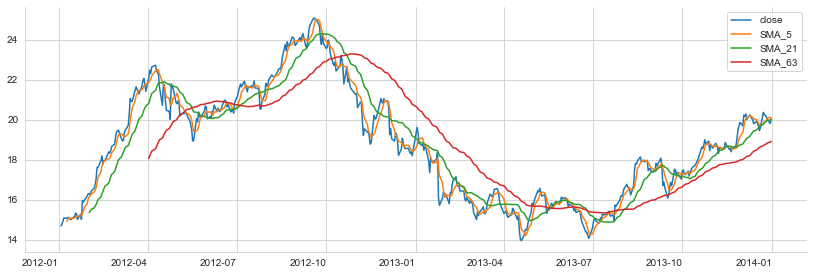

In [20]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### Exponential Moving Average (EMA)

For price series $P_t$ with a window of length $N$, the exponential moving average at time $t$ $EMA_t$ is recursively defined as the weighted average of the current price and most recent previous $EMA_{t-1}$, where the weights $\alpha$ and $1-\alpha$ are defined as below:
$$\begin{align*}
\text{EMA}(N)_t&= \alpha P_t  + (1-\alpha)\text{EMA}(N)_{t-1} \\
\alpha&=\frac{2}{N+1}\\
\end{align*}$$

In [21]:
df = price_sample.loc['2012', ['close']]

In [22]:
for t in [5, 21, 63]:
    df[f'EMA_{t}'] = talib.EMA(df.close,
                               timeperiod=t)

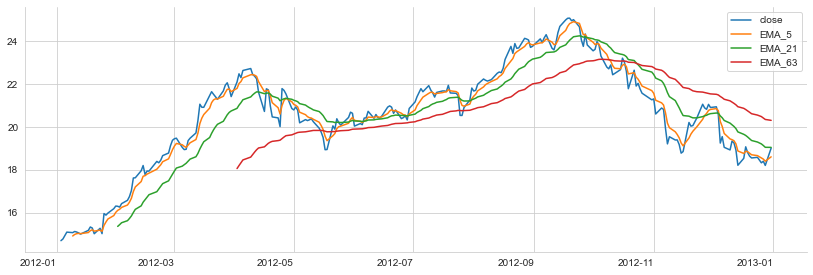

In [23]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### Weighted Moving Average (WMA)

For price series $P_t$ with a window of length $N$, the weighted moving average at time $t$ is computed as such that the weight of each data point corresponds to its index within the window:
$$\text{WMA}(N)_t= \frac{P_{t-N+1}+2P_{t-N+2}+3P_{t-N+3}+NP_{t}}{N(N+1)/2}$$

In [24]:
df = price_sample.loc['2012', ['close']]

In [25]:
for t in [5, 21, 63]:
    df[f'WMA_{t}'] = talib.WMA(df.close,
                               timeperiod=t)

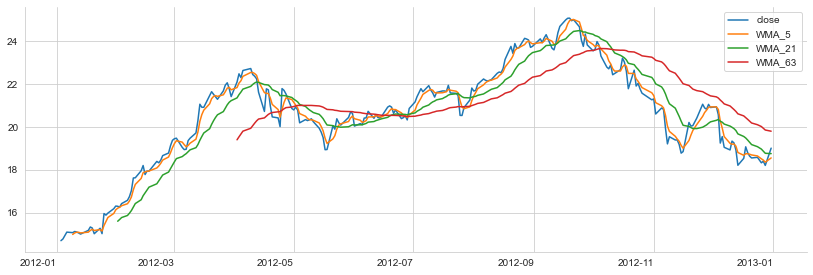

In [26]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### Double Exponential Moving Average (DEMA)

The double exponential moving average for a price series $P_t$ at time $t$, $\text{DEMA}_t$ is based on the EMA yet designed to react faster to changes in price. I t is computed as the difference between twice the current EMA and the EMA applied to the current EMA, labeled $\text{EMA}_2(N)_t$:

$$\text{DEMA}(N)_t=2\times\text{EMA}(N)_t-\text{EMA}_2(N)_t$$

Since the calculation uses $\text{EMA}_2$, DEMA needs 2 * N - 1 samples to start producing values.

In [27]:
df = price_sample.loc['2012', ['close']]

In [28]:
for t in [5, 21, 63]:
    df[f'DEMA_{t}'] = talib.DEMA(df.close,
                                timeperiod=t)

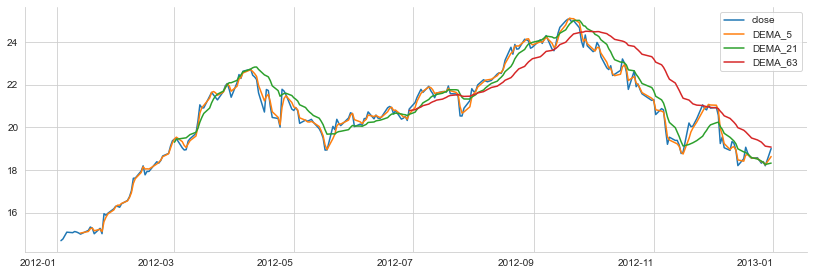

In [29]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### Triple Exponential Moving Average (TEMA)

The triple exponential moving average for a price series $P_t$ at time $t$, $\text{TEMA}_t$ is based on the EMA yet designed to react faster to changes in price and indicate short-term price direction. It is computed as the difference between three time the difference between the current EMA and the EMA applied to the current EMA, $\text{EMA}_2$, with addition of the EMA of the $\text{EMA}_2$, labeled as $\text{EMA}_3$:

$$\text{TEMA}(N)_t=3\times\left[\text{EMA}(N)_t-\text{EMA}_2(N)_t\right] + \text{EMA}_3(N)_t$$

Since the calculation uses $\text{EMA}_3$, DEMA needs 3 * N - 2 samples to start producing values.

In [30]:
df = price_sample.loc['2012', ['close']]

In [31]:
for t in [5, 21, 63]:
    df[f'TEMA_{t}'] = talib.TEMA(df.close,
                                timeperiod=t)

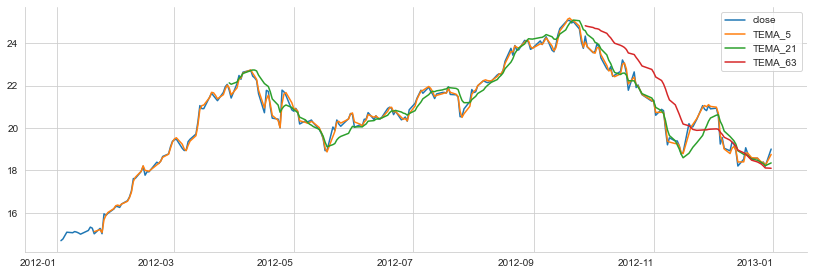

In [32]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### Triangular Moving Average (TRIMA)

The triangular moving average (TRIMA) with window length N for a price series $P_t$ at time $t$, $\text{TRIMA}(N)_t$ is a weighted average of the last N $SMA(N)_t$ values. In other words, it applies the SMA to a time series of SMA values:

$$\text{TRIMA}(N)_t=\frac{1}{N}\sum_{i=1}^N \text{SMA}(N)_{t-N+i}$$

Since the calculation applies the SMA(N) to the SMA(N), TRIMA needs 2 * N - 1 samples to start producing values.

In [33]:
df = price_sample.loc['2012', ['close']]

In [34]:
for t in [5, 21, 63]:
    df[f'TRIMA_{t}'] = talib.TRIMA(df.close,
                                timeperiod=t)

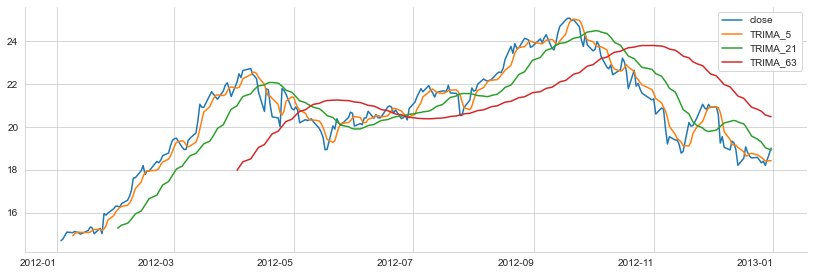

In [35]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### Kaufman Adaptive Moving Average (KAMA)

The computation of the Kaufman adaptive moving average aims to take into account changes in market volatility. See [here](https://www.technicalindicators.net/indicators-technical-analysis/152-kama-kaufman-adaptive-moving-average) for details on the slightly more involved computation.

In [36]:
df = price_sample.loc['2012', ['close']]

In [37]:
for t in [5, 21, 63]:
    df[f'KAMA_{t}'] = talib.KAMA(df.close,
                                timeperiod=t)

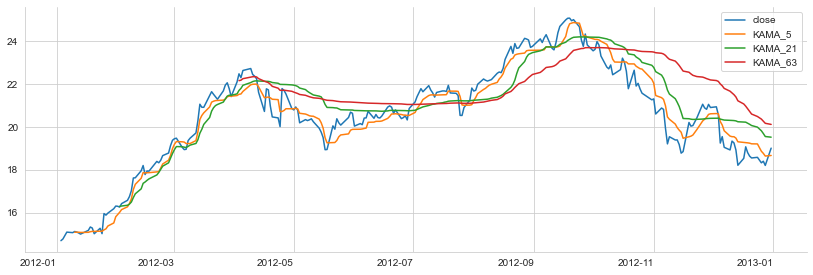

In [38]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

###  MESA Adaptive Moving Average (MAMA)

The MESA Adaptive Moving Average (MAMA) is an exponential moving average that adapts to price movement based on the rate change of phase as measured by the Hilbert Transform Discriminator (see below). In addition to the price series, MAMA accepts two additional parameters, `fastlimit` and `slowlimit` that control the maximum and minimum alpha value that should be applied to the EMA using when calculating MAMA.

In [39]:
df = price_sample.loc['2012', ['close']]

In [40]:
len(talib.MAMA(df.close,
                         fastlimit=.5,
                         slowlimit=.05))

2

In [41]:
mama, fama = talib.MAMA(df.close,
                        fastlimit=.5,
                        slowlimit=.05)
df['mama'] = mama
df['fama'] = fama

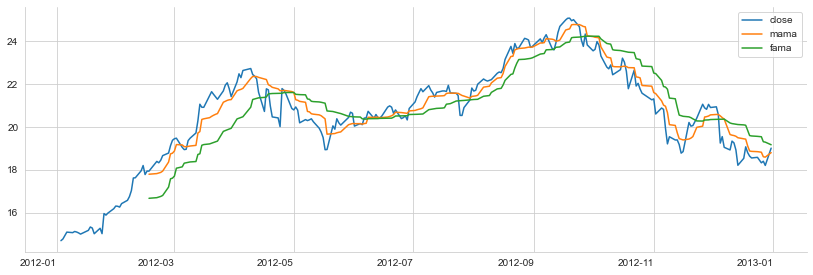

In [42]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### Comparison

In [43]:
df = price_sample.loc['2012', ['close']]
t = 21

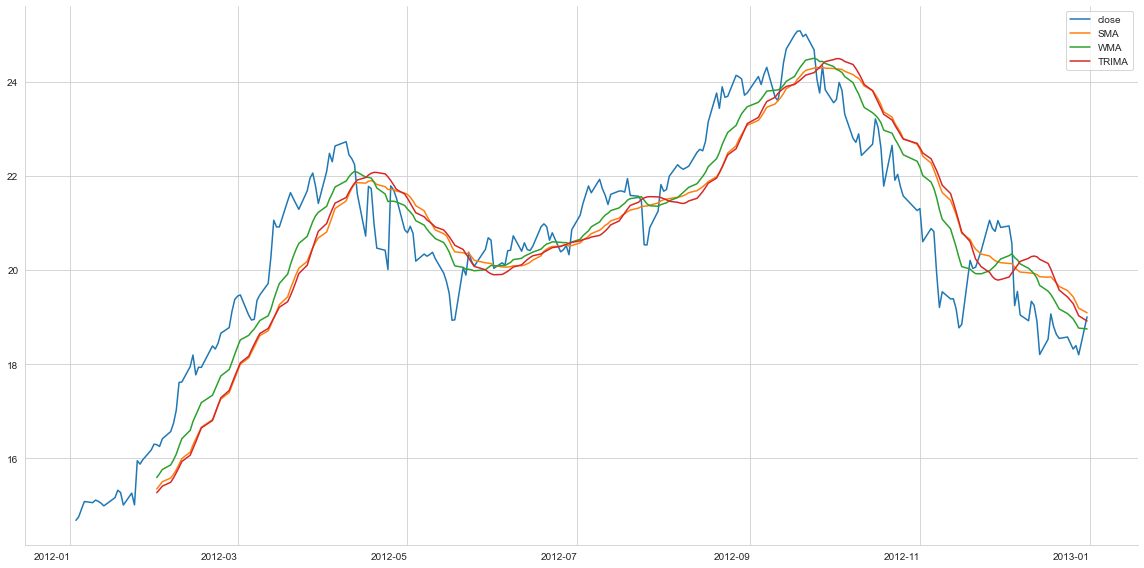

In [44]:
df['SMA'] = talib.SMA(df.close, timeperiod=t)
df['WMA'] = talib.WMA(df.close, timeperiod=t)
df['TRIMA'] = talib.TRIMA(df.close, timeperiod=t)

ax = df[['close', 'SMA', 'WMA', 'TRIMA']].plot(figsize=(16, 8), rot=0)

sns.despine()
ax.set_xlabel('')
plt.tight_layout();

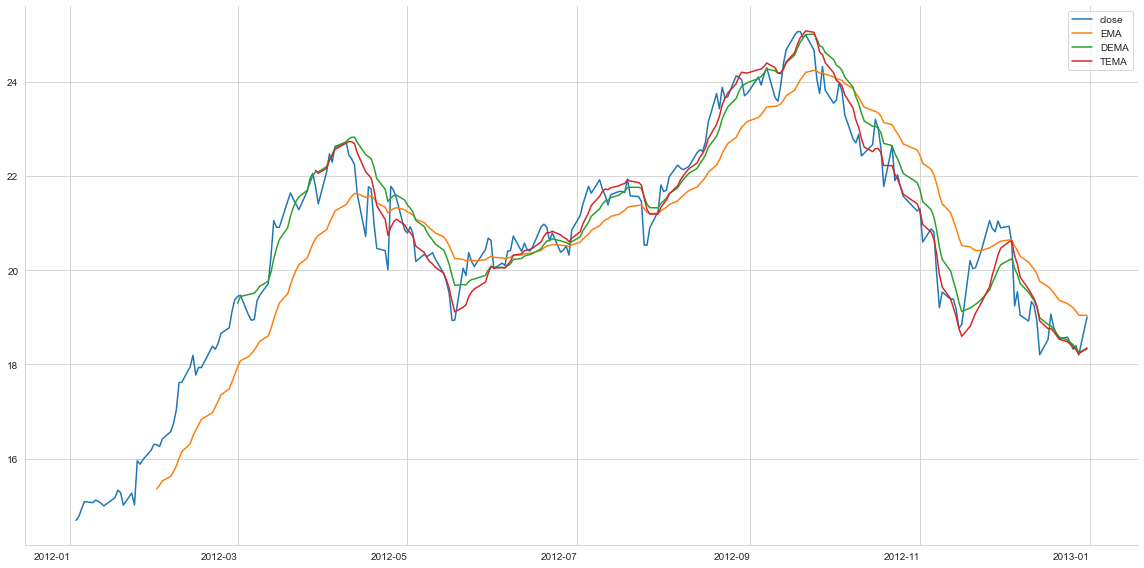

In [45]:
df['EMA'] = talib.EMA(df.close, timeperiod=t)
df['DEMA'] = talib.DEMA(df.close, timeperiod=t)
df['TEMA'] = talib.TEMA(df.close, timeperiod=t)

ax = df[['close', 'EMA', 'DEMA', 'TEMA']].plot(figsize=(16, 8), rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

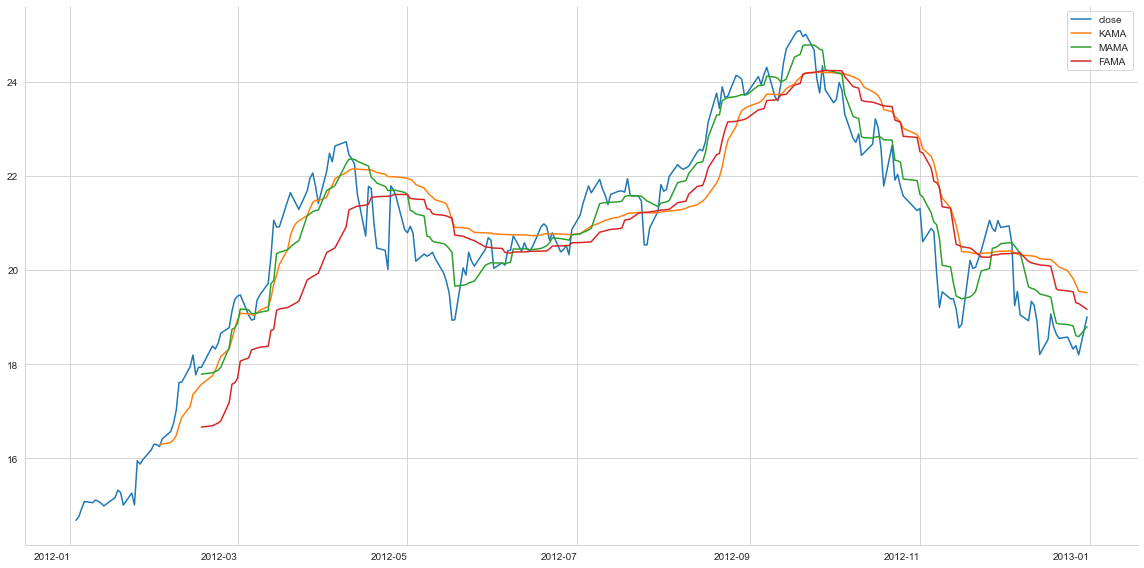

In [46]:
df['KAMA'] = talib.KAMA(df.close, timeperiod=t)
mama, fama = talib.MAMA(df.close,
                        fastlimit=.5,
                        slowlimit=.05)
df['MAMA'] = mama
df['FAMA'] = fama
ax = df[['close', 'KAMA', 'MAMA', 'FAMA']].plot(figsize=(16, 8), rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

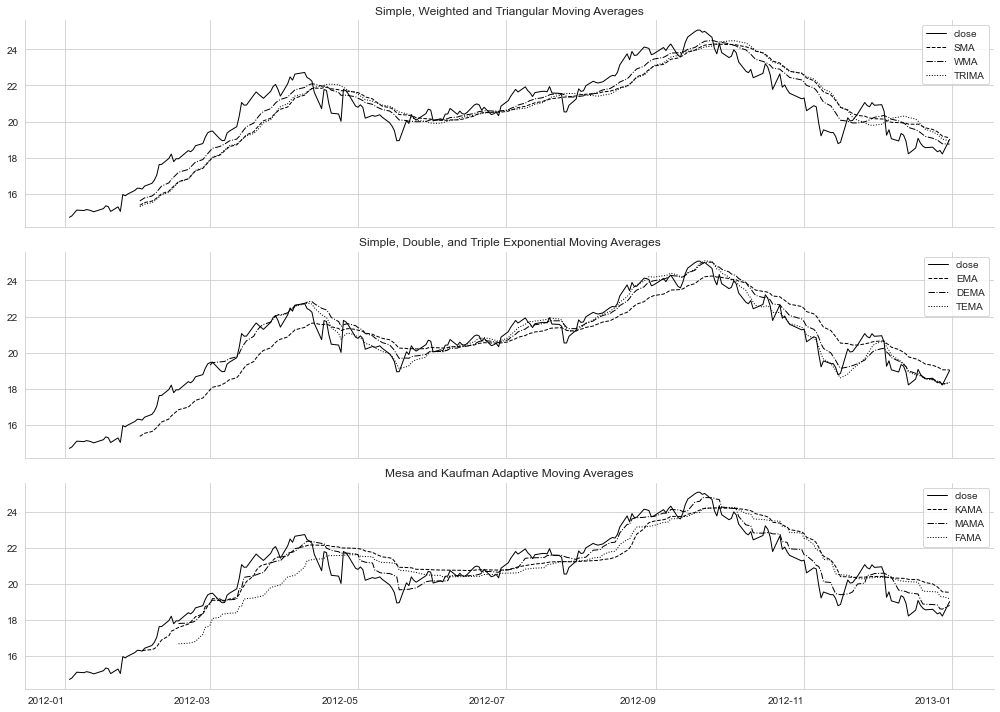

In [47]:
fig, axes = plt.subplots(nrows=3, figsize=(14, 10), sharex=True, sharey=True)


df[['close', 'SMA', 'WMA', 'TRIMA']].plot(rot=0,
                                          ax=axes[0],
                                          title='Simple, Weighted and Triangular Moving Averages',
                                          lw=1, style=['-', '--', '-.', ':'], c='k')
df[['close', 'EMA', 'DEMA', 'TEMA']].plot(rot=0, ax=axes[1],
                                          title='Simple, Double, and Triple Exponential Moving Averages',
                                          lw=1, style=['-', '--', '-.', ':'], c='k')

df[['close', 'KAMA', 'MAMA', 'FAMA']].plot(rot=0, ax=axes[2],
                                          title='Mesa and Kaufman Adaptive Moving Averages',
                                          lw=1, style=['-', '--', '-.', ':'], c='k')
axes[2].set_xlabel('')
sns.despine()
plt.tight_layout();

## Overlap Studies

|Function  |Name  |
|:---|:---|
|BBANDS               |Bollinger Bands|
|HT_TRENDLINE         |Hilbert Transform - Instantaneous Trendline|
|MAVP                 |Moving average with variable period|
|MA                   |Moving average|
|MIDPOINT             |MidPoint over period|
|MIDPRICE             |Midpoint Price over period|
|SAR                  |Parabolic SAR|
|SAREXT               |Parabolic SAR - Extended|

### Bollinger Bands

In [48]:
s = talib.BBANDS(df.close,   # Number of periods (2 to 100000)
                 timeperiod=20,
                 nbdevup=2,    # Deviation multiplier for lower band
                 nbdevdn=2,    # Deviation multiplier for upper band
                 matype=1      # default: SMA
                 )

In [49]:
bb_bands = ['upper', 'middle', 'lower']

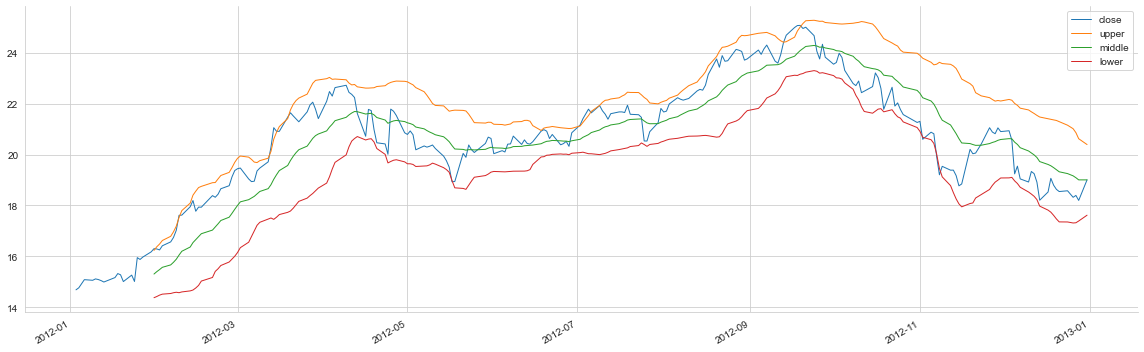

In [50]:
df = price_sample.loc['2012', ['close']]
df = df.assign(**dict(zip(bb_bands, s)))
ax = df.loc[:, ['close'] + bb_bands].plot(figsize=(16, 5), lw=1)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

#### Normalized squeeze & mean reversion indicators

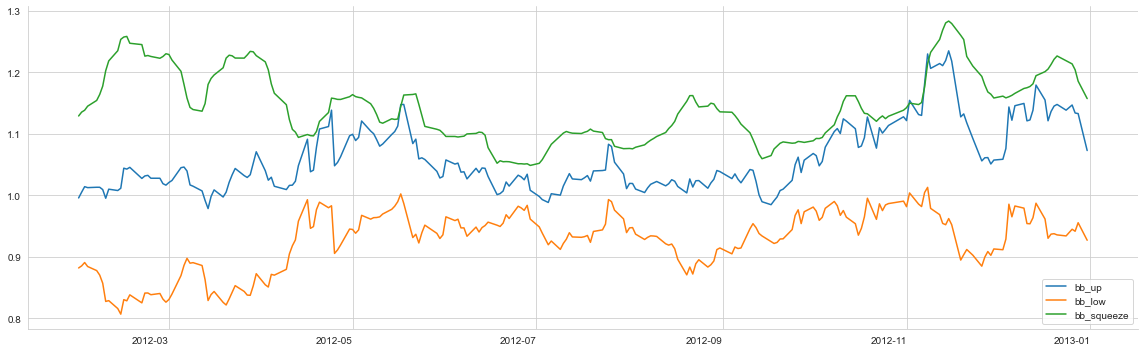

In [51]:
fig, ax = plt.subplots(figsize=(16,5))
df.upper.div(df.close).plot(ax=ax, label='bb_up')
df.lower.div(df.close).plot(ax=ax, label='bb_low')
df.upper.div(df.lower).plot(ax=ax, label='bb_squeeze', rot=0)

plt.legend()
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [52]:
def compute_bb_indicators(close, timeperiod=20, matype=0):
    high, mid, low = talib.BBANDS(close, 
                                  timeperiod=20,
                                  matype=matype)
    bb_up = high / close -1
    bb_low = low / close -1
    squeeze = (high - low) / close
    return pd.DataFrame({'BB_UP': bb_up, 
                         'BB_LOW': bb_low, 
                         'BB_SQUEEZE': squeeze}, 
                        index=close.index)

In [53]:
data = (data.join(data
                  .groupby(level='ticker')
                  .close
                  .apply(compute_bb_indicators)))

ValueError: level name ticker is not the name of the index

#### Visualize Distribution

In [ ]:
bb_indicators = ['BB_UP', 'BB_LOW', 'BB_SQUEEZE']

In [ ]:
q = .01
with sns.axes_style('white'):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 4), sharey=True, sharex=True)
    df_ = data[bb_indicators]
    df_ = df_.clip(df_.quantile(q), 
                   df_.quantile(1-q), axis=1)
    for i, indicator in enumerate(bb_indicators):
        sns.distplot(df_[indicator], ax=axes[i])
    fig.suptitle('Distribution of normalized Bollinger Band indicators', fontsize=12)

    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.93);

#### Plot outlier price series

In [ ]:
ncols = len(bb_indicators)
fig, axes = plt.subplots(ncols=ncols, figsize=(5*ncols, 4), sharey=True)
for i, indicator in enumerate(bb_indicators):
    ticker, date = data[indicator].nlargest(1).index[0]
    p = data.loc[idx[ticker, :], :].close.reset_index('ticker', drop=True)
    p = p.div(p.dropna().iloc[0])
    p.plot(ax=axes[i], label=ticker, rot=0)
    c = axes[i].get_lines()[-1].get_color()
    axes[i].axvline(date, ls='--', c=c, lw=1)
    ticker, date = data[indicator].nsmallest(1).index[0]
    p = data.loc[idx[ticker, :], :].close.reset_index('ticker', drop=True)
    p = p.div(p.dropna().iloc[0])
    p.plot(ax=axes[i], label=ticker, rot=0)    
    c = axes[i].get_lines()[-1].get_color()
    axes[i].axvline(date, ls='--', c=c, lw=1)
    axes[i].set_title(indicator.upper())
    axes[i].legend()
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout();

### Hilbert Transform - Instantaneous Trendline

The Hilbert Transform generates inphase and quadrature components of a de-trended real-valued signal like a price series to analyze variations of the instantaneous phase and amplitude.

HTTrendline returns the price series value after the Dominant Cycle of the analytic signal as generated by the Hilbert Transform has been removed. The Dominant Cycle can be thought of as being the "most likely" period (in the range of 10 to 40) of a sine function of the Price Series. See [here](http://www2.wealth-lab.com/WL5Wiki/HTTrendLine.ashx) for additional detail on computation.

In [ ]:
df = price_sample.loc['2012', ['close']]
df['HT_TRENDLINE'] = talib.HT_TRENDLINE(df.close)

In [ ]:
ax = df.plot(figsize=(16, 4), style=['-', '--'], rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

#### Compute Hilbert-based normalized indicator

In [ ]:
data['HT'] = (data
              .groupby(level='ticker', group_keys=False)
              .close
              .apply(talib.HT_TRENDLINE)
              .div(data.close).sub(1))

In [ ]:
q=0.005
with sns.axes_style('white'):
    sns.distplot(data.HT.clip(data.HT.quantile(q), data.HT.quantile(1-q)))
    sns.despine();

### Parabolic SAR

The Parabolic SAR aims to identify trend reversals. It is a trend-following (lagging) indicator that can be used to set a trailing stop loss or determine entry or exit points. It is usually represented in a price chart as a set of dots near the price bars. Generally, when these dots are above the price, it signals a downward trend, and an upward trend if the dots are below the price. The change in the direction of the dots can be interpreted as a  trade signal. However, the indicator is not as reliable in a flat or range-bound markt. It is compute as follows:

$$\text{SAR}_t=\text{SAR}_{t-1} + \alpha (\text{EP}-\text{SAR}_{t-1})$$

EP (the extreme point) is a record kept during each trend that represents the highest value reached by the price during the current uptrend – or lowest value during a downtrend. During each period, if a new maximum (or minimum) is observed, the EP is updated with that value.

The α value represents the acceleration factor and is typically set initially to a value of 0.02. This factor increases by α each time a new EP is recorded. The rate will then quicken to a point where the SAR converges towards the price. To prevent it from getting too large, a maximum value for the acceleration factor is normally set to 0.20.

For additional detail, see [wikipedia](https://en.wikipedia.org/wiki/Parabolic_SAR); there is also an [extended SAR](http://www.tadoc.org/indicator/SAR.htm).

In [ ]:
df = price_sample.loc['2012', ['close', 'high', 'low']]
df['SAR'] = talib.SAR(df.high, df.low, 
                      acceleration=0.02, # common value
                      maximum=0.2)       

In [ ]:
ax = df[['close', 'SAR']].plot(figsize=(16, 4), style=['-', '--'], title='Parabolic SAR')
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

#### Normalized SAR indicator

In [ ]:
def compute_sar_indicator(x, acceleration=.02, maximum=0.2):
    sar = talib.SAR(x.high, 
                    x.low,
                    acceleration=acceleration,
                    maximum=maximum)
    return sar/x.close - 1

In [ ]:
data['SAR'] = (data.groupby(level='ticker', group_keys=False)
                  .apply(compute_sar_indicator))

In [ ]:
q=0.005
with sns.axes_style('white'):
    sns.distplot(data.SAR.clip(data.SAR.quantile(q), data.SAR.quantile(1-q)))
    sns.despine()

## Momentum Indicators

|Function|             Name|
|:---|:---|
|PLUS_DM|              Plus Directional Movement|
|MINUS_DM|             Minus Directional Movement|
|PLUS_DI|              Plus Directional Indicator|
|MINUS_DI|             Minus Directional Indicator|
|DX|                   Directional Movement Index|
|ADX|                  Average Directional Movement Index|
|ADXR|                 Average Directional Movement Index Rating|
|APO|                  Absolute Price Oscillator|
|PPO|                  Percentage Price Oscillator|
|AROON|                Aroon|
|AROONOSC|             Aroon Oscillator|
|BOP|                  Balance Of Power|
|CCI|                  Commodity Channel Index|
|CMO|                  Chande Momentum Oscillator|
|MACD|                 Moving Average Convergence/Divergence|
|MACDEXT|              MACD with controllable MA type|
|MACDFIX|              Moving Average Convergence/Divergence Fix 12/26|
|MFI|                  Money Flow Index|
|MOM|                  Momentum|
|RSI|                  Relative Strength Index|
|STOCH|                Stochastic|
|STOCHF|               Stochastic Fast|
|STOCHRSI|             Stochastic Relative Strength Index|
|TRIX|                 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA|
|ULTOSC|               Ultimate Oscillator|
|WILLR|                Williams' %R|

### Average Directional Movement Index (ADX)

The ADX combines of two other indicators, namely the positive and directional indicators (PLUS_DI and MINUS_DI), which in turn build on the positive and directional movement (PLUS_DM and MINUS_DM). For additional details see [Wikipdia](https://en.wikipedia.org/wiki/Average_directional_movement_index) and [Investopedia](https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp).

#### Plus/Minus Directional Movement (PLUS_DM/MINUS_DM)

For a price series $P_t$ with daily highs $P^H_t$ and daily lows $P^L_t$, the directional movement tracks the absolute size of price moves over a timeperiod T as follows:

$$\begin{align*}
\text{Up}_t & =P^H_t-P^H_{t-T} \\
\text{Down}_t & = P^L_{t-T} - P^L_t\\
\text{PLUS_DM}_t & = 
\begin{cases}
\text{Up}_t & \text{if Up}_t > \text{Down}_t \text{and Up}_t > 0 \\
0 & \text{otherwise}
\end{cases} \\
\text{MINUS_DM}_t & = 
\begin{cases}
\text{Down}_t & \text{if Down}_t > \text{Up}_t \text{and Down}_t < 0 \\
0 & \text{otherwise}
\end{cases}
\end{align*}$$

In [ ]:
df = price_sample.loc['2012': '2013', ['high', 'low', 'close']]

In [ ]:
df['PLUS_DM'] = talib.PLUS_DM(df.high, df.low, timeperiod=10)
df['MINUS_DM'] = talib.MINUS_DM(df.high, df.low, timeperiod=10)

In [ ]:
ax = df[['close', 'PLUS_DM', 'MINUS_DM']].plot(figsize=(14, 4),
                                               secondary_y=[
                                                   'PLUS_DM', 'MINUS_DM'],
                                               style=['-', '--', '_'],
                                              rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

#### Plus/Minus Directional Index (PLUS_DI/MINUS_DI)

`PLUS_DI` and `MINUS_DI` are the simple moving average of `PLUS_DM` and `MINUS_DM`, respectively, each divided by the average true range (`ATR`, see below).

The smoothed moving average is calculated over the number of periods selected, and the average true range is a smoothed average of the true ranges.

In [ ]:
df = price_sample.loc['2012': '2013', ['high', 'low', 'close']]

In [ ]:
df['PLUS_DI'] = talib.PLUS_DI(df.high, df.low, df.close, timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(df.high, df.low, df.close, timeperiod=14)

In [ ]:
ax = df[['close', 'PLUS_DI', 'MINUS_DI']].plot(figsize=(14, 5), style=['-', '--', '_'], rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

#### Average directional movement index (ADX)

The ADX is the (simple) moving average of the absolute value of the difference between PLUS_DI and MINUS_DI, divided by their sum:

$$
\text{ADX}=100\times\text{SMA}(N)_t\left|\frac{\text{PLUS_DI}_t-\text{MINUS_DI}_t}{\text{PLUS_DI}_t+\text{MINUS_DI}_t}\right|
$$

|ADX Value|	Trend Strength|
|:---|:---|
|0-25 |	Absent or Weak Trend|
|25-50 |	Strong Trend|
|50-75 |	Very Strong Trend|
|75-100 |	Extremely Strong Trend|

In [ ]:
df = price_sample.loc[:, ['high', 'low', 'close']]

In [ ]:
df['ADX'] = talib.ADX(df.high, 
                      df.low, 
                      df.close, 
                      timeperiod=14)

In [ ]:
ax = df[['close', 'ADX']].plot(figsize=(14, 4), secondary_y='ADX', style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [ ]:
def compute_adx(x, timeperiod=14):
    return talib.ADX(x.high, 
                    x.low,
                    x.close,
                    timeperiod=timeperiod)

In [ ]:
data['ADX'] = (data.groupby(level='ticker', group_keys=False)
                  .apply(compute_adx))

#### Visualize distribution

In [ ]:
with sns.axes_style("white"):
    sns.distplot(data.ADX)
    sns.despine();

#### Average Directional Movement Index Rating

Averages the current ADX and the ADX T periods ago.

In [ ]:
df = price_sample.loc[:, ['high', 'low', 'close']]

In [ ]:
df['ADXR'] = talib.ADXR(df.high,
                        df.low,
                        df.close,
                        timeperiod=14)

In [ ]:
ax = df[['close', 'ADXR']].plot(figsize=(14, 5),
                                secondary_y='ADX',
                                style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [ ]:
def compute_adxr(x, timeperiod=14):
    return talib.ADXR(x.high, 
                    x.low,
                    x.close,
                    timeperiod=timeperiod)

In [ ]:
data['ADXR'] = (data.groupby(level='ticker', group_keys=False)
                .apply(compute_adxr))

In [ ]:
with sns.axes_style('white'):
    sns.distplot(data.ADXR)
    sns.despine();

### Absolute Price Oscillator (APO)

The absolute Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as an absolute value. The EMA windows usually contain 26 and 12 data points, respectively.

In [ ]:
df = price_sample.loc[:, ['close']]

In [ ]:
df['APO'] = talib.APO(df.close,
                      fastperiod=12,
                      slowperiod=26,
                      matype=0)

In [ ]:
ax = df.plot(figsize=(14,4), secondary_y='APO', rot=0, style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

### Percentage Price Oscillator (PPO)

The Percentage Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as a percentage value and thus comparable across assets. The EMA windows usually contain 26 and 12 data points, respectively. 

In [ ]:
df = price_sample.loc[:, ['close']]

In [ ]:
df['PPO'] = talib.PPO(df.close,
                      fastperiod=12,
                      slowperiod=26,
                      matype=0)

In [ ]:
ax = df.plot(figsize=(14,4), secondary_y=['APO', 'PPO'], rot=0,  style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [ ]:
data['PPO'] = (data.groupby(level='ticker')
               .close
               .apply(talib.PPO, 
                      fastperiod=12, 
                      slowperiod=26, 
                      matype=1))

In [ ]:
q = 0.001
with sns.axes_style("white"):
    sns.distplot(data.PPO.clip(lower=data.PPO.quantile(q),
                               upper=data.PPO.quantile(1-q)))
    sns.despine()

### Aroon Oscillator

#### Aroon Up/Down Indicator

The indicator measures the time between highs and the time between lows over a time period. It computes an AROON_UP and an AROON_DWN indicator as follows:

$$
\begin{align*}
\text{AROON_UP}&=\frac{T-\text{Periods since T period High}}{T}\times 100\\
\text{AROON_DWN}&=\frac{T-\text{Periods since T period Low}}{T}\times 100
\end{align*}
$$

In [ ]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [ ]:
aroonup, aroondwn = talib.AROON(high=df.high,
                                low=df.low,
                                timeperiod=14)
df['AROON_UP'] = aroonup
df['AROON_DWN'] = aroondwn

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
df.close.plot(ax=axes[0], rot=0)
df[['AROON_UP', 'AROON_DWN']].plot(ax=axes[1], rot=0)

axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

#### Aroon Oscillator

The Aroon Oscillator is simply the difference between the Aroon Up and Aroon Down indicators.

In [ ]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [ ]:
df['AROONOSC'] = talib.AROONOSC(high=df.high,
                                low=df.low,
                                timeperiod=14)

In [ ]:
ax = df[['close', 'AROONOSC']].plot(figsize=(14,4), rot=0, style=['-', '--'], secondary_y='AROONOSC')
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [ ]:
data['AARONOSC'] = (data.groupby('ticker',
                                 group_keys=False)
                    .apply(lambda x: talib.AROONOSC(high=x.high,
                                                    low=x.low,
                                                    timeperiod=14)))

In [ ]:
with sns.axes_style("white"):
    sns.distplot(data.AARONOSC)
    sns.despine()

### Balance Of Power (BOP)

The Balance of Power (BOP) intends to measure the strength of buyers relative to sellers in the market by assessing the ability of each side to drive prices. It is computer as the difference between the close and the open price, divided by the difference between the high and the low price: 

$$
\text{BOP}_t= \frac{P_t^\text{Close}-P_t^\text{Open}}{P_t^\text{High}-P_t^\text{Low}}
$$

In [ ]:
df = price_sample.loc['2013', ['open', 'high', 'low', 'close']]

In [ ]:
df['BOP'] = talib.BOP(open=df.open,
                      high=df.high,
                      low=df.low,
                      close=df.close)

In [ ]:
axes = df[['close', 'BOP']].plot(figsize=(14, 7), rot=0, subplots=True, title=['AAPL', 'BOP'], legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

In [ ]:
by_ticker = data.groupby('ticker', group_keys=False)

In [ ]:
data['BOP'] = (by_ticker
               .apply(lambda x: talib.BOP(x.open,
                                          x.high,
                                          x.low,
                                          x.close)))

In [ ]:
q = 0.0005
with sns.axes_style("white"):
    sns.distplot(data.BOP.clip(lower=data.BOP.quantile(q),
                               upper=data.BOP.quantile(1-q)))
    sns.despine()

### Commodity Channel Index (CCI)

The Commodity Channel Index (CCI) measures the difference between the current *typical* price, computed as the average of current low, high and close price and the historical average price. A positive (negative) CCI indicates that price is above (below) the historic average. When CCI is below zero, the price is below the hsitoric average. It is computed as:

$$
\begin{align*}
\bar{P_t}&=\frac{P_t^H+P_t^L+P_t^C}{3}\\
\text{CCI}_t & =\frac{\bar{P_t} - \text{SMA}(T)_t}{0.15\sum_{t=i}^T |\bar{P_t}-\text{SMA}(N)_t|/T}
\end{align*}
$$

In [ ]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [ ]:
df['CCI'] = talib.CCI(high=df.high,
                      low=df.low,
                      close=df.close,
                      timeperiod=14)

In [ ]:
axes = df[['close', 'CCI']].plot(figsize=(14, 7), 
                                 rot=0, 
                                 subplots=True, 
                                 title=['AAPL', 'CCI'], 
                                 legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [ ]:
data['CCI'] = (by_ticker
               .apply(lambda x: talib.CCI(x.high,
                                          x.low,
                                          x.close,
                                          timeperiod=14)))

In [ ]:
with sns.axes_style('white'):
    sns.distplot(data.CCI)
    sns.despine();

### Moving Average Convergence/Divergence (MACD)

Moving Average Convergence Divergence (MACD) is a trend-following (lagging) momentum indicator that shows the relationship between two moving averages of a security’s price. It is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

The TA-Lib implementation returns the MACD value and its signal line, which is the 9-day EMA of the MACD. In addition, the MACD-Histogram measures the distance between the indicator and its signal line.

In [ ]:
df = price_sample.loc['2013', ['close']]

In [ ]:
macd, macdsignal, macdhist = talib.MACD(df.close,
                                        fastperiod=12,
                                        slowperiod=26,
                                        signalperiod=9)
df['MACD'] = macd
df['MACDSIG'] = macdsignal
df['MACDHIST'] = macdhist

In [ ]:
axes = df.plot(figsize=(14, 8),
               rot=0,
               subplots=True,
               title=['AAPL', 'MACD', 'MACDSIG', 'MACDHIST'],
               legend=False)

axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [ ]:
def compute_macd(close, fastperiod=12, slowperiod=26, signalperiod=9):
    macd, macdsignal, macdhist = talib.MACD(close,
                                            fastperiod=fastperiod,
                                            slowperiod=slowperiod,
                                            signalperiod=signalperiod)
    return pd.DataFrame({'MACD': macd,
                         'MACD_SIGNAL': macdsignal,
                         'MACD_HIST': macdhist},
                        index=close.index)

In [ ]:
data = (data.join(data
                  .groupby(level='ticker')
                  .close
                  .apply(compute_macd)))

In [ ]:
macd_indicators = ['MACD', 'MACD_SIGNAL', 'MACD_HIST']

In [ ]:
data[macd_indicators].corr()

In [ ]:
q = .005
with sns.axes_style('white'):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 4))
    df_ = data[macd_indicators]
    df_ = df_.clip(df_.quantile(q), 
                   df_.quantile(1-q), axis=1)
    for i, indicator in enumerate(macd_indicators):
        sns.distplot(df_[indicator], ax=axes[i])
    sns.despine()
    fig.tight_layout();

### Chande Momentum Oscillator (CMO)

The Chande Momentum Oscillator (CMO) intends to measure momentum on both up and down days. It is calculated as the difference between the sum of gains and losses over at time period T, divided by the sum of all price movement over the same period. It oscillates between +100 and -100.

In [ ]:
df = price_sample.loc['2013', ['close']]

In [ ]:
df['CMO'] = talib.CMO(df.close, timeperiod=14)

In [ ]:
ax = df.plot(figsize=(14, 4), rot=0, secondary_y=['CMO'], style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

Not included due to high correlation with PPO.

In [ ]:
# data['CMO'] = (by_ticker
#                .apply(lambda x: talib.CMO(x.close,
#                                           timeperiod=14)))

In [ ]:
# sns.distplot(data.CMO);

### Money Flow Index

The Money Flow Index (MFI) incorporates price and volume information to identify overbought or oversold conditions.  The indicator is typically calculated using 14 periods of data. An MFI reading above 80 is considered overbought and an MFI reading below 20 is considered oversold.

In [ ]:
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]

In [ ]:
df['MFI'] = talib.MFI(df.high, 
                      df.low, 
                      df.close, 
                      df.volume, 
                      timeperiod=14)

In [ ]:
axes = df[['close', 'volume', 'MFI']].plot(figsize=(14, 8),
                                           rot=0,
                                           subplots=True,
                                           title=['Close', 'Volume', 'MFI'],
                                           legend=False)
axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [ ]:
data['MFI'] = (by_ticker
               .apply(lambda x: talib.MFI(x.high,
                                          x.low,
                                          x.close,
                                          x.volume,
                                          timeperiod=14)))

In [ ]:
with sns.axes_style('white'):
    sns.distplot(data.MFI)
    sns.despine()

### Relative Strength Index

RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold. A high RSI (usually above 70) indicates overbought and a low RSI (typically below 30) indicates oversold. It first computes the average price change for a given number (often 14) of prior trading days with rising and falling prices, respectively as $\text{up}_t$ and $\text{down}_t$. Then, the RSI is computed as:
$$
\text{RSI}_t=100-\frac{100}{1+\frac{\text{up}_t}{\text{down}_t}}
$$



In [ ]:
df = price_sample.loc['2013', ['close']]

In [ ]:
df['RSI'] = talib.RSI(df.close, timeperiod=14)

In [ ]:
ax = df.plot(figsize=(14, 4), rot=0, secondary_y=['RSI'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [ ]:
data['RSI'] = (by_ticker
               .apply(lambda x: talib.RSI(x.close,
                                          timeperiod=14)))

In [ ]:
with sns.axes_style('white'):
    sns.distplot(data.RSI)
    sns.despine();

#### Stochastic RSI (STOCHRSI)

The Stochastic Relative Strength Index (STOCHRSI) is based on the RSI just described and intends to identify crossovers as well as overbought and oversold conditions. It compares the distance of the current RSI to the lowest RSI over a given time period T to the maximum range of values the RSI has assumed for this period. It is computed as follows:

$$
\text{STOCHRSI}_t= \frac{\text{RSI}_t-\text{RSI}_t^L(T)}{\text{RSI}_t^H(T)-\text{RSI}_t^L(T)}
$$

The TA-Lib implementation offers more flexibility than the original "Unsmoothed stochastic RSI" version by Chande and Kroll (1993). To calculate the original indicator, keep the `timeperiod` and `fastk_period` equal. 

The return value `fastk` is the unsmoothed RSI. The `fastd_period` is used to compute a smoothed STOCHRSI, which  is returned as `fastd`. If you do not care about STOCHRSI smoothing, just set `fastd_period` to 1 and ignore the `fastd` output.

Reference: "Stochastic RSI and Dynamic Momentum Index" by Tushar Chande and Stanley Kroll Stock&Commodities V.11:5 (189-199)


In [ ]:
df = price_sample.loc['2013', ['close']]

In [ ]:
fastk, fastd = talib.STOCHRSI(df.close,
                              timeperiod=14, 
                              fastk_period=14, 
                              fastd_period=3, 
                              fastd_matype=0)
df['fastk'] = fastk
df['fastd'] = fastd

In [ ]:
ax = df.plot(figsize=(14, 4),
             rot=0,
             secondary_y=['fastk', 'fastd'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [ ]:
data['STOCHRSI'] = (by_ticker.apply(lambda x: talib.STOCHRSI(x.close,
                                                             timeperiod=14,
                                                             fastk_period=14,
                                                             fastd_period=3,
                                                             fastd_matype=0)[0]))

### Stochastic (STOCH)

A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. Stochastic oscillators are based on the idea that closing prices should confirm the trend.

For stochastic (STOCH), there are four different lines: `FASTK`, `FASTD`, `SLOWK` and `SLOWD`. The `D` is the signal line usually drawn over its corresponding `K` function.

$$
\begin{align*}
& K^\text{Fast}(T_K) & = &\frac{P_t-P_{T_K}^L}{P_{T_K}^H-P_{T_K}^L}* 100 \\
& D^\text{Fast}(T_{\text{FastD}}) & = & \text{MA}(T_{\text{FastD}})[K^\text{Fast}]\\
& K^\text{Slow}(T_{\text{SlowK}}) & = &\text{MA}(T_{\text{SlowK}})[K^\text{Fast}]\\
& D^\text{Slow}(T_{\text{SlowD}}) & = &\text{MA}(T_{\text{SlowD}})[K^\text{Slow}]
\end{align*}
$$
  

The $P_{T_K}^L$, $P_{T_K}^H$, and $P_{T_K}^L$ are the extreme values among the last $T_K$ period.
 $K^\text{Slow}$ and $D^\text{Fast}$ are equivalent when using the same period. 

In [ ]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [ ]:
slowk, slowd = talib.STOCH(df.high,
                           df.low,
                           df.close,
                           fastk_period=14,
                           slowk_period=3,
                           slowk_matype=0,
                           slowd_period=3,
                           slowd_matype=0)
df['STOCH'] = slowd / slowk

In [ ]:
ax = df[['close', 'STOCH']].plot(figsize=(14, 4),
                                 rot=0,
                                 secondary_y='STOCH', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [ ]:
def compute_stoch(x, fastk_period=14, slowk_period=3, 
                  slowk_matype=0, slowd_period=3, slowd_matype=0):
    slowk, slowd = talib.STOCH(x.high, x.low, x.close,
                           fastk_period=fastk_period,
                           slowk_period=slowk_period,
                           slowk_matype=slowk_matype,
                           slowd_period=slowd_period,
                           slowd_matype=slowd_matype)
    return slowd/slowk-1

In [ ]:
data['STOCH'] = by_ticker.apply(compute_stoch)
data.loc[data.STOCH.abs() > 1e5, 'STOCH'] = np.nan

In [ ]:
q = 0.005
with sns.axes_style('white'):
    sns.distplot(data.STOCH.clip(lower=data.STOCH.quantile(q),
                             upper=data.STOCH.quantile(1-q)));

    sns.despine();

### Ultimate Oscillator (ULTOSC)

The Ultimate Oscillator (ULTOSC), developed by Larry Williams, measures the average difference of the current close to the previous lowest price over three time frames (default: 7, 14, and 28) to avoid overreacting to short-term price changes and incorporat short, medium, and long-term market trends. It first computes the buying pressure, $\text{BP}_t$, then sums it over the three periods $T_1, T_2, T_3$, normalized by the True Range ($\text{TR}_t$.
$$
\begin{align*}
\text{BP}_t & = P_t^\text{Close}-\min(P_{t-1}^\text{Close}, P_t^\text{Low})\\ 
\text{TR}_t & = \max(P_{t-1}^\text{Close}, P_t^\text{High})-\min(P_{t-1}^\text{Close}, P_t^\text{Low})
\end{align*}
$$

ULTOSC is then computed as a weighted average over the three periods as follows:
$$
\begin{align*}
\text{Avg}_t(T) & = \frac{\sum_{i=0}^{T-1} \text{BP}_{t-i}}{\sum_{i=0}^{T-1} \text{TR}_{t-i}}\\
\text{ULTOSC}_t & = 100*\frac{4\text{Avg}_t(7) + 2\text{Avg}_t(14) + \text{Avg}_t(28)}{4+2+1}
\end{align*}
$$

In [ ]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [ ]:
df['ULTOSC'] = talib.ULTOSC(df.high,
                            df.low,
                            df.close,
                            timeperiod1=7,
                            timeperiod2=14,
                            timeperiod3=28)

In [ ]:
ax = df[['close', 'ULTOSC']].plot(figsize=(14, 4),
                                  rot=0,
                                  secondary_y='ULTOSC', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [ ]:
def compute_ultosc(x, timeperiod1=7, timeperiod2=14, timeperiod3=28):
    return talib.ULTOSC(x.high,
                        x.low,
                        x.close,
                        timeperiod1=timeperiod1,
                        timeperiod2=timeperiod2,
                        timeperiod3=timeperiod3)

In [ ]:
data['ULTOSC'] = by_ticker.apply(compute_ultosc)

In [ ]:
with sns.axes_style('white'):
    sns.distplot(data.ULTOSC)
    sns.despine();

### Williams' %R (WILLR)

Williams %R, also known as the Williams Percent Range, is a momentum indicator that moves between 0 and -100 and measures overbought and oversold levels to identify entry and exit points. It is similar to the Stochastic oscillator and compares the current closing price $P_t^\text{Close}$ to the range of highest ($P_T^\text{High}$) and lowest ($P_T^\text{Low}$) prices over the last T periods (typically 14). The indicators is computed as:

$$
\text{WILLR}_t = \frac{P_T^\text{High}-P_t^\text{Close}}{P_T^\text{High}-P_T^\text{Low}}
$$


In [ ]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [ ]:
df['WILLR'] = talib.WILLR(df.high,
                          df.low,
                          df.close,
                          timeperiod=14)

In [ ]:
ax = df[['close', 'WILLR']].plot(figsize=(14, 4),
                                 rot=0,
                                 secondary_y='WILLR', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [ ]:
data['WILLR'] = by_ticker.apply(lambda x: talib.WILLR(x.high, x.low, x.close, timeperiod=14))

In [ ]:
with sns.axes_style('white'):
    sns.distplot(data.WILLR)
    sns.despine();

## Volume Indicators

|Function|             Name|
|:---|:---|
|AD|                   Chaikin A/D Line|
|ADOSC|                Chaikin A/D Oscillator|
|OBV|                  On Balance Volume|

### Chaikin A/D Line

The Chaikin Advance/Decline or Accumulation/Distribution Line (AD) is a volume-based indicator designed to measure the cumulative flow of money into and out of an asset. The indicator assumes that the degree of buying or selling pressure can be determined by the location of the close, relative to the high and low for the period. There is buying (sellng) pressure when a stock closes in the upper (lower) half of a period's range. The intention is to signal a change in direction when the indicator diverges from the security price.

The Accumulation/Distribution Line is a running total of each period's Money Flow Volume. It is calculated as follows:

1. The Money Flow Multiplier (MFI) is the relationship of the close to the high-low range:
2. The MFI is multiplied by the period's volume $V_t$ to come up with a Money Flow Volume (MFV). 
3. A running total of the Money Flow Volume forms the Accumulation Distribution Line:
$$
\begin{align*}
&\text{MFI}_t&=\frac{P_t^\text{Close}-P_t^\text{Low}}{P_t^\text{High}-P_t^\text{Low}}\\
&\text{MFV}_t&=\text{MFI}_t \times V_t\\
&\text{AD}_t&=\text{AD}_{t-1}+\text{MFV}_t
\end{align*}
$$

In [ ]:
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]

In [ ]:
df['AD'] = talib.AD(df.high,
                    df.low,
                    df.close,
                    df.volume)

In [ ]:
ax = df[['close', 'AD']].plot(figsize=(14, 4),
                              rot=0,
                              secondary_y='AD', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

Divide by average volume to normalize across assets.

In [ ]:
data['AD'] = by_ticker.apply(lambda x: talib.AD(x.high, x.low, x.close, x.volume)/x.volume.mean())

In [ ]:
data.AD.replace((np.inf, -np.inf), np.nan).dropna().describe()

In [ ]:
q = 0.005
AD = data.AD.replace((np.inf, -np.inf), np.nan).dropna()
with sns.axes_style('white'):
    sns.distplot(AD.clip(lower=AD.quantile(q),
                     upper=AD.quantile(1-q)));

    sns.despine();

### Chaikin A/D Oscillator (ADOSC)

The Chaikin A/D Oscillator (ADOSC) is the Moving Average Convergence Divergence indicator (MACD) applied to the Chaikin A/D Line. The Chaikin Oscillator intends to predict changes in the Accumulation/Distribution Line.

It is computed as the difference between the 3-day exponential moving average and the 10-day exponential moving average of the Accumulation/Distribution Line.

In [ ]:
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]

In [ ]:
df['ADOSC'] = talib.ADOSC(df.high,
                          df.low,
                          df.close,
                          df.volume,
                          fastperiod=3,
                          slowperiod=10)

In [ ]:
ax = df[['close', 'ADOSC']].plot(figsize=(14, 4),
                                 rot=0,
                                 secondary_y='ADOSC', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [ ]:
data['ADOSC'] = by_ticker.apply(lambda x: talib.ADOSC(x.high,
                                                      x.low,
                                                      x.close,
                                                      x.volume,
                                                      fastperiod=3,
                                                      slowperiod=10)/x.rolling(14).volume.mean())

In [ ]:
q = 0.0001
with sns.axes_style('white'):
    sns.distplot(data.ADOSC.clip(lower=data.ADOSC.quantile(q),
                             upper=data.ADOSC.quantile(1-q)))
    sns.despine();

### On Balance Volume (OBV)

The On Balance Volume indicator (OBV) is a cumulative momentum indicator that relates volume to price change. It assumes that OBV changes precede price changes because smart money can be seen flowing into the security by a rising OBV. When the public then moves into the security, both the security and OBV will rise.

The current OBV is computed by adding (subtracting) the current volume to the last OBV if the security closes higher (lower) than the previous close.

$$
\text{OBV}_t = 
\begin{cases}
\text{OBV}_{t-1}+V_t & \text{if }P_t>P_{t-1}\\
\text{OBV}_{t-1}-V_t & \text{if }P_t<P_{t-1}\\
\text{OBV}_{t-1} & \text{otherwise}
\end{cases}
$$

In [ ]:
df = price_sample.loc['2013', ['close', 'volume']]

In [ ]:
df['OBV'] = talib.OBV(df.close,
                      df.volume)

In [ ]:
ax = df[['close', 'OBV']].plot(figsize=(14, 4),
                               rot=0,
                               secondary_y='OBV', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [ ]:
data['OBV'] = by_ticker.apply(lambda x: talib.OBV(x.close,
                                                  x.volume)/x.expanding().volume.mean())

In [ ]:
q = 0.0025
with sns.axes_style('white'):
    sns.distplot(data.OBV.clip(lower=data.OBV.quantile(q),
                               upper=data.OBV.quantile(1-q)))
    sns.despine()

## Volatility Indicators

|Function|             Name|
|:---|:---|
|TRANGE|               True Range|
|ATR|                  Average True Range|
|NATR|                 Normalized Average True Range|

### ATR

The Average True Range indicator (ATR) shows volatility of the market. It was introduced by Welles Wilder (1978)  and has been used as a component of numerous other indicators since. It aims to anticipate changes in trend such that the higher its value, the higher the probability of a trend change; the lower the indicator’s value, the weaker the current trend.

It is computed as the simple moving average for a period T of the True Range (TRANGE), which measures volatility as the absolute value of the largest recent trading range:
$$
\text{TRANGE}_t = \max\left[P_t^\text{High} - P_t^\text{low}, \left| P_t^\text{High} - P_{t-1}^\text{Close}\right|, \left| P_t^\text{low} - P_{t-1}^\text{Close}\right|\right]
$$

In [ ]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [ ]:
df['ATR'] = talib.ATR(df.high,
                      df.low,
                      df.close,
                      timeperiod=14)

In [ ]:
ax = df[['close', 'ATR']].plot(figsize=(14, 4),
                          rot=0,
                          secondary_y='ATR', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

#### Compute normalized version of ATR using rolling mean of price

In [ ]:
data['ATR'] = by_ticker.apply(lambda x: talib.ATR(x.high,
                                                  x.low,
                                                  x.close,
                                                  timeperiod=14)/x.rolling(14).close.mean())

In [ ]:
q = 0.001
with sns.axes_style('white'):
    sns.distplot(data.ATR.clip(upper=data.ATR.quantile(1-q)))
    sns.despine()

### NATR

The Normalized Average True Range (NATR) is a normalized version of the ATR computed as follows:

$$
\text{NATR}_t = \frac{\text{ATR}_t(T)}{P_t^\text{Close}} * 100
$$

Normalization make the ATR function more relevant in the folllowing scenarios:
- Long term analysis where the price changes drastically.
- Cross-market or cross-security ATR comparison.

In [ ]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [ ]:
df['NATR'] = talib.NATR(df.high,
                        df.low,
                        df.close,
                        timeperiod=14)

In [ ]:
ax = df[['close', 'NATR']].plot(figsize=(14, 4),
                           rot=0,
                           secondary_y='NATR', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

Not included in data due to high correlation with ATR.

In [ ]:
# data['NATR'] = by_ticker.apply(lambda x: talib.NATR(x.high,
#                                                     x.low,
#                                                     x.close,
#                                                     timeperiod=14))

In [ ]:
# q = 0.001
# sns.distplot(data.NATR.clip(upper=data.NATR.quantile(1-q)));

## Rolling Factor Betas

In [ ]:
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=2005)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']

In [ ]:
factors = factor_data.columns[:-1]
factors

In [ ]:
t = 1
ret = f'ret_{t:02}'

windows = [21, 63, 252]
for window in windows:
    print(window)
    betas = []
    for ticker, df in data.groupby('ticker', group_keys=False):
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF

        rolling_ols = RollingOLS(endog=model_data[ret], 
                                 exog=sm.add_constant(model_data[factors]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const':'ALPHA'})
        result = factor_model.assign(ticker=ticker).set_index('ticker', append=True).swaplevel()
        betas.append(result)
    betas = pd.concat(betas).rename(columns=lambda x: f'{x}_{window:02}')
    data = data.join(betas)

## Size proxy

In [ ]:
data['size_factor'] = by_ticker.close.apply(lambda x: x.fillna(method='bfill').div(x.iloc[0]))

In [ ]:
data['size_proxy'] = data.marketcap.mul(data.size_factor).div(1e6)

# References
<hr style = "border:2px solid black" ></hr>


- [typeerror: string indices must be integer pandas datareader](https://stackoverflow.com/questions/74912452/typeerror-string-indices-must-be-integer-pandas-datareader)
- [yfinance Python Tutorial (2023)](https://analyzingalpha.com/yfinance-python)
- [This notebook source code](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/24_alpha_factor_library/02_common_alpha_factors.ipynb)
    
